In [1]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import keras.utils as kutils
import keras.backend as backend

from utils import plot_profile
from utils import load_data
from utils import r_squared
from utils import create_pseudo_linear_1
from utils import create_pseudo_linear_P
from utils import create_LSTM
from utils import P


NUM_BINS = 47
CURRENT_BINS = [ f'bin_{k}' for k in range(30, 1430, 30) ]
PREVIOUS_BINS = { p: [ f'{current_bin}_prev_{p}' for current_bin in CURRENT_BINS ] for p in range(1, P + 1) }
VOLUMES = 'volumes'
PREVIOUS_VOLUMES = { p: f'volumes_prev_{p}' for p in range(1, P + 1) }

# Traded Volumes

In [28]:
data = load_data()

(102235, 292)

,Daily Volumes,ADV
datetime,,
2018-01-01,7579.134130,78862.701486
2018-01-02,20078.092111,78862.701486
2018-01-03,15905.667639,78862.701486
2018-01-04,21343.555117,78862.701486
2018-01-05,23251.491125,78862.701486
...,...,...
2023-10-27,32330.401060,78862.701486
2023-10-28,16880.131440,78862.701486
2023-10-29,20685.521760,78862.701486


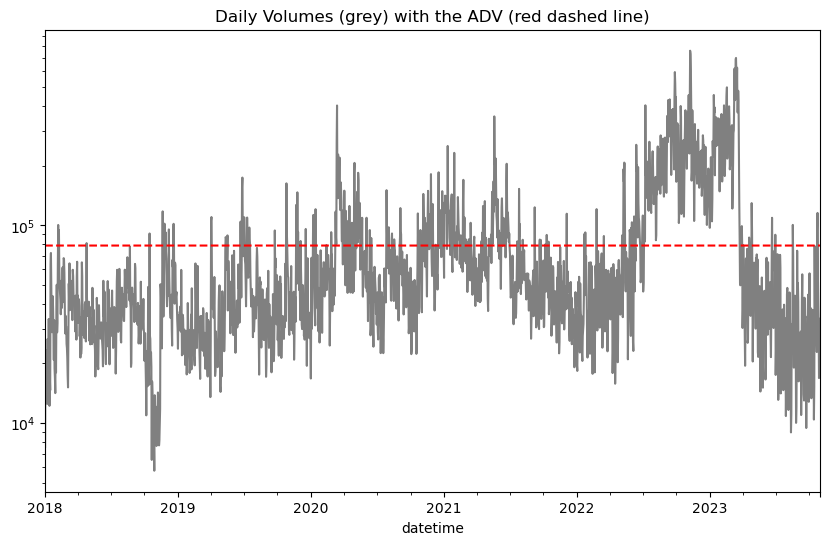

In [27]:
daily_volumes = data[['volumes']].resample('1D').sum().rename(columns={ 'volumes': 'Daily Volumes' })
daily_volumes['ADV'] = daily_volumes['Daily Volumes'].mean()
plt.figure(figsize=(10, 6))
daily_volumes['Daily Volumes'].plot(logy=True, color='grey')
daily_volumes['ADV'].plot(logy=True, color='red', linestyle='--')
plt.title('Daily Volumes (grey) with the ADV (red dashed line)')
daily_volumes

# Seasonnality of the traded volumes 

## Average profile on the data set

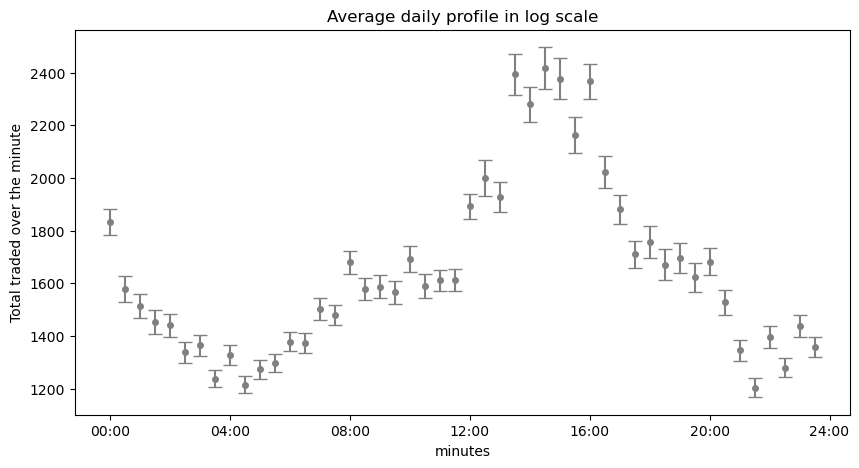

In [2]:
plt.figure(figsize=(10, 5))
plot_profile(labels=True, ylabel=True, title=True)

## Profile variations with time

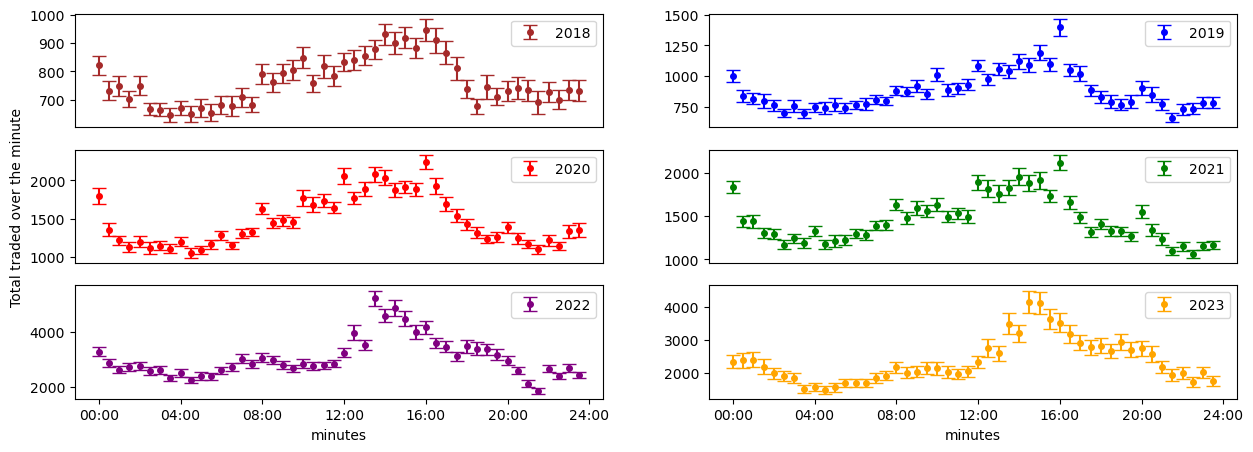

In [3]:
plt.figure(figsize=(15, 5))
plt.subplot(321)
plot_profile('2018', color='brown')
plt.legend()
plt.subplot(322)
plot_profile('2019', color='blue')
plt.legend()
plt.subplot(323)
plot_profile('2020', color='red', ylabel=True)
plt.legend()
plt.subplot(324)
plot_profile('2021', color='green')
plt.legend()
plt.subplot(325)
plot_profile('2022', color='purple', labels=True)
plt.legend()
plt.subplot(326)
plot_profile('2023', color='orange', labels=True)
plt.legend()

# Autoregressive property of the residuals

## Linear regression

In [5]:
delta_min = np.quantile(data.delta, .0001)
delta_max = np.quantile(data.delta, .9999)
x = data.delta_prev.values
y = data.delta.values
y = y[~np.isnan(x)]
x = x[~np.isnan(x)]
x = x[~np.isnan(y)]
y = y[~np.isnan(y)]
model = sm.OLS(y, x).fit()
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.502
Model:                            OLS   Adj. R-squared (uncentered):              0.502
Method:                 Least Squares   F-statistic:                          1.030e+05
Date:                Sun, 05 Nov 2023   Prob (F-statistic):                        0.00
Time:                        16:21:24   Log-Likelihood:                     -8.7207e+05
No. Observations:              102235   AIC:                                  1.744e+06
Df Residuals:                  102234   BIC:                                  1.744e+06
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

## Lag-plot

Text(0, 0.5, '$V_{t}$')

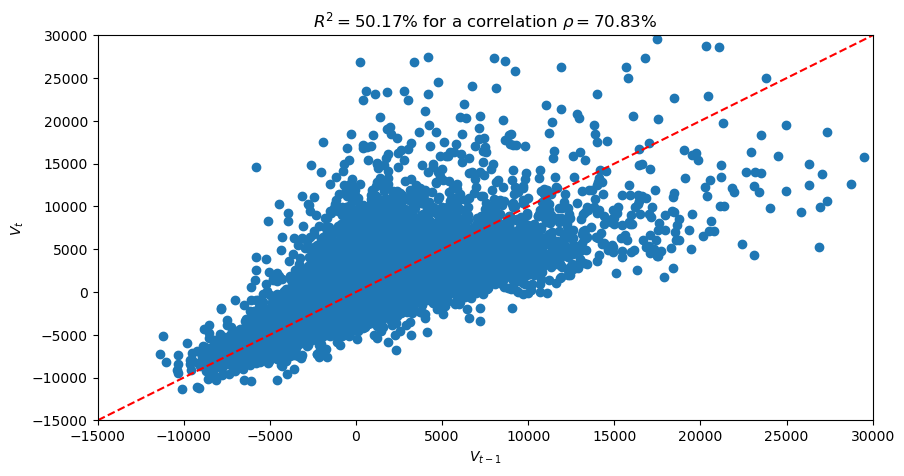

In [31]:
R2 = int(10000*model.rsquared)/100
corr = int(10000*np.sqrt(R2/100))/100
plt.figure(figsize=(10, 5))
plt.xlim([-15000, 30000])
plt.ylim([-15000, 30000])
plt.plot(x, y, 'o')
plt.plot([- x.max(), x.max()], [- x.max(), x.max()], 'r--')
plt.title(r'$R^2 =$' + str(R2) + r'% for ' + r'a correlation $\rho =$' + str(corr) + r'%')
plt.xlabel(r'$V_{t - 1}$')
plt.ylabel(r'$V_{t}$')

# Training an order $1$ Pseudo-Linear Model for benchmarking purposes

$$
\begin{aligned}
V(t) &= \sum_{b=0}^{B - 1} \alpha_b \cdot I_{b}(t) + \beta_1 \cdot z(t - 1) + \epsilon_t \\
z(t) &= V(t) - \sum_{b=0}^{B - 1} \alpha_b \cdot I_{b}(t) \\
\end{aligned}
$$

In [7]:
kutils.set_random_seed(0)

n_train = int(2 / 3 * len(data))
n_val = int(1 / 3 * len(data))

train = data.copy()[:n_train]

columns = train.columns
input_data_bins_current = train[CURRENT_BINS].values.astype(int)
input_data_bins_prev = train[PREVIOUS_BINS[1]].values.astype(int)
input_data_v_prev = train[[PREVIOUS_VOLUMES[1]]].values
output_data = train[[VOLUMES]].values
X_train = [input_data_bins_current.copy(), input_data_bins_prev.copy(), input_data_v_prev.copy()]
y_train = output_data.copy()

val = data.copy()[n_train:n_train + n_val]

columns = val.columns
input_data_bins_current = val[CURRENT_BINS].values.astype(int)
input_data_bins_prev = val[PREVIOUS_BINS[1]].values.astype(int)
input_data_v_prev = val[[PREVIOUS_VOLUMES[1]]].values
output_data = val[[VOLUMES]].values

X_val_1 = [input_data_bins_current.copy(), input_data_bins_prev.copy(), input_data_v_prev.copy()]
y_val_1 = output_data.copy()

pseudo_linear = create_pseudo_linear_1(num_bins=NUM_BINS)
backend.set_value(pseudo_linear.optimizer.learning_rate, 0.0001)
pseudo_linear.fit(X_train, y_train, epochs=100, batch_size=100, validation_data=(X_val_1, y_val_1))

Epoch 1/100
682/682 [==============================] - 1s 830us/step - loss: 6386474.0000 - r_squared: -4.2954 - val_loss: 43399112.0000 - val_r_squared: -6.5272
Epoch 2/100
682/682 [==============================] - 0s 668us/step - loss: 5912304.0000 - r_squared: -3.8546 - val_loss: 40104416.0000 - val_r_squared: -5.9594
Epoch 3/100
682/682 [==============================] - 0s 703us/step - loss: 5466253.0000 - r_squared: -3.4881 - val_loss: 37000644.0000 - val_r_squared: -5.4251
Epoch 4/100
682/682 [==============================] - 0s 670us/step - loss: 5044496.0000 - r_squared: -3.1325 - val_loss: 34062800.0000 - val_r_squared: -4.9200
Epoch 5/100
682/682 [==============================] - 0s 675us/step - loss: 4645243.0000 - r_squared: -2.7928 - val_loss: 31271142.0000 - val_r_squared: -4.4408
Epoch 6/100
682/682 [==============================] - 0s 667us/step - loss: 4268365.0000 - r_squared: -2.4639 - val_loss: 28636222.0000 - val_r_squared: -3.9892
Epoch 7/100
682/682 [=======

1065/1065 [==============================] - 1s 400us/step
tf.Tensor(0.68235445, shape=(), dtype=float32)


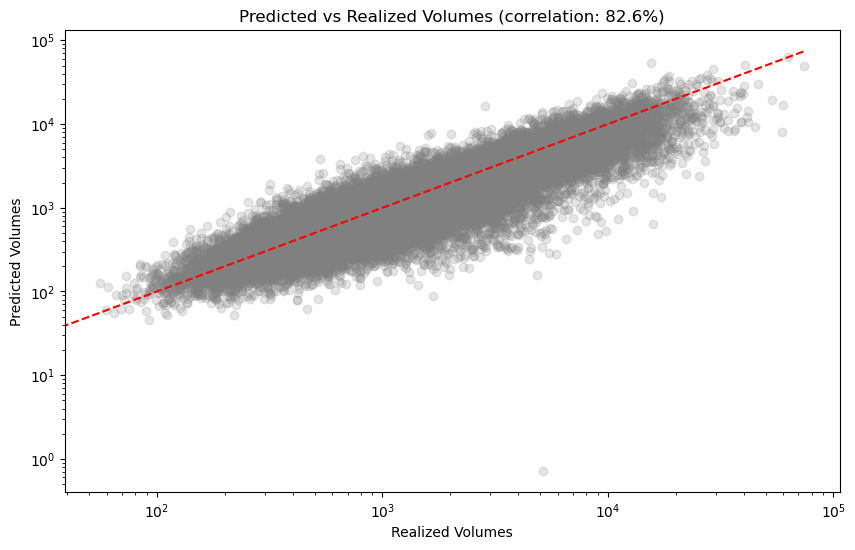

In [8]:
y_pred = pseudo_linear.predict(X_val_1)
R2 = r_squared(backend.constant(y_val_1), backend.constant(y_pred))
correlation = int(np.sqrt(R2)*10000)/100 if R2 > 0 else np.nan
print(R2)
# Plot the R^2 values
plt.figure(figsize=(10, 6))
plt.title(f'Predicted vs Realized Volumes (correlation: {correlation}%)')
plt.plot(y_val_1, y_pred, 'o', color='grey', alpha=.2)
plt.plot([y_val_1.min(), y_val_1.max()], [y_val_1.min(), y_val_1.max()], '--', color='red')
plt.xlabel("Realized Volumes")
plt.ylabel("Predicted Volumes")
plt.xscale('log')
plt.yscale('log')
plt.show()

# Training an order $P$ Pseudo-Linear Model to be better

$$
\begin{aligned}
V(t) &= \sum_{b=0}^{B - 1} \alpha_b \cdot I_{b}(t) + \sum_{p=1}^{P}\beta_p \cdot z(t - p) + \epsilon_t \\
z(t) &= V(t) - \sum_{b=0}^{B - 1} \alpha_b \cdot I_{b}(t) \\
\end{aligned}
$$

In [9]:
kutils.set_random_seed(0)

n_train = int(2 / 3 * len(data))
n_val = int(1 / 3 * len(data))

train = data.copy()[:n_train]

columns = train.columns
X_train = [ train[CURRENT_BINS].values.astype(int) ]
for p in range(1, P + 1):
    X_train += [ train[PREVIOUS_BINS[p]].values.astype(int) ]
for p in range(1, P + 1):
    X_train += [ train[[PREVIOUS_VOLUMES[p]]].values ]
y_train = train[[VOLUMES]].values.copy()

val = data.copy()[n_train:n_train + n_val]

columns = val.columns
X_val = [ val[CURRENT_BINS].values.astype(int) ]
for p in range(1, P + 1):
    X_val += [ val[PREVIOUS_BINS[p]].values.astype(int) ]
for p in range(1, P + 1):
    X_val += [ val[[PREVIOUS_VOLUMES[1]]].values ]
y_val = val[[VOLUMES]].values.copy()

pseudo_linear_P = create_pseudo_linear_P(num_bins=NUM_BINS)
backend.set_value(pseudo_linear_P.optimizer.learning_rate, 0.0001)
pseudo_linear_P.fit(X_train, y_train, epochs=100, batch_size=100, validation_data=(X_val, y_val))

Epoch 1/12
682/682 [==============================] - 1s 1ms/step - loss: 11907712.0000 - r_squared: -9.3930 - val_loss: 79174248.0000 - val_r_squared: -12.7187
Epoch 2/12
682/682 [==============================] - 1s 866us/step - loss: 9143356.0000 - r_squared: -6.8088 - val_loss: 58620188.0000 - val_r_squared: -9.1559
Epoch 3/12
682/682 [==============================] - 1s 864us/step - loss: 6937849.0000 - r_squared: -4.8749 - val_loss: 42340360.0000 - val_r_squared: -6.3443
Epoch 4/12
682/682 [==============================] - 1s 857us/step - loss: 5199905.5000 - r_squared: -3.3440 - val_loss: 29632864.0000 - val_r_squared: -4.1604
Epoch 5/12
682/682 [==============================] - 1s 904us/step - loss: 3864782.7500 - r_squared: -2.1578 - val_loss: 20079126.0000 - val_r_squared: -2.5296
Epoch 6/12
682/682 [==============================] - 1s 858us/step - loss: 2880860.0000 - r_squared: -1.3001 - val_loss: 13221589.0000 - val_r_squared: -1.3709
Epoch 7/12
682/682 [==============

1065/1065 [==============================] - 0s 348us/step
tf.Tensor(0.68552756, shape=(), dtype=float32)


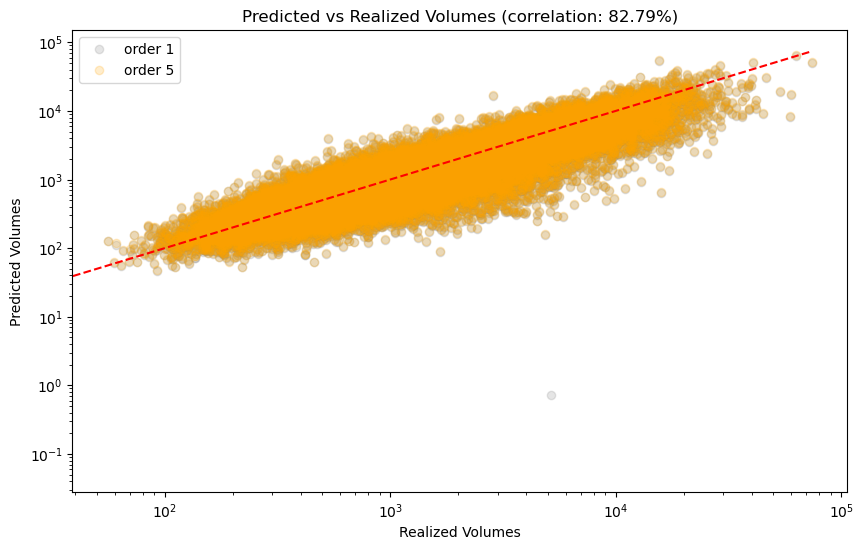

In [10]:
y_pred_P = pseudo_linear_P.predict(X_val)
y_pred_1 = pseudo_linear.predict(X_val_1)
R2 = r_squared(backend.constant(y_val), backend.constant(y_pred_P))
correlation = int(np.sqrt(R2)*10000)/100 if R2 > 0 else np.nan
print(R2)
# Plot the R^2 values
plt.figure(figsize=(10, 6))
plt.title(f'Predicted vs Realized Volumes (correlation: {correlation}%)')
plt.plot(y_val_1, y_pred_1, 'o', color='grey', alpha=.2, label='order 1')
plt.plot(y_val, y_pred_P, 'o', color='orange', alpha=.2, label=f'order {P}')
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], '--', color='red')
plt.xlabel("Realized Volumes")
plt.ylabel("Predicted Volumes")
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

# Training an LSTM Model

$$
\begin{aligned}
V(t) &= \sum_{b=0}^{B - 1} \alpha_b \cdot I_{b}(t) + f \left(z(t - 1), \cdots, z(t - P)\right) + \epsilon_t \\
z(t) &= V(t) - \sum_{b=0}^{B - 1} \alpha_b \cdot I_{b}(t) \\
\end{aligned}
$$

$f$ is LSTM network to fully grasp non-linear temporal dependencies.

In [11]:
kutils.set_random_seed(0)

n_train = int(2 / 3 * len(data))
n_val = int(1 / 3 * len(data))

train = data.copy()[:n_train]

columns = train.columns
X_train = [ train[CURRENT_BINS].values.astype(int) ]
for p in range(1, P + 1):
    X_train += [ train[PREVIOUS_BINS[p]].values.astype(int) ]
for p in range(1, P + 1):
    X_train += [ train[[PREVIOUS_VOLUMES[p]]].values ]
y_train = train[[VOLUMES]].values.copy()

val = data.copy()[n_train:n_train + n_val]

columns = val.columns
X_val = [ val[CURRENT_BINS].values.astype(int) ]
for p in range(1, P + 1):
    X_val += [ val[PREVIOUS_BINS[p]].values.astype(int) ]
for p in range(1, P + 1):
    X_val += [ val[[PREVIOUS_VOLUMES[p]]].values ]
y_val = val[[VOLUMES]].values.copy()

lstm = create_LSTM(num_bins=NUM_BINS)
backend.set_value(lstm.optimizer.learning_rate, 0.0001)

lstm.fit(X_train, y_train, epochs=100, batch_size=100, validation_data=(X_val, y_val))

Epoch 1/100
682/682 [==============================] - 8s 9ms/step - loss: 1291890.5000 - r_squared: 0.0214 - val_loss: 4486517.0000 - val_r_squared: 0.1118
Epoch 2/100
682/682 [==============================] - 6s 9ms/step - loss: 905561.1875 - r_squared: 0.3437 - val_loss: 4143479.0000 - val_r_squared: 0.1666
Epoch 3/100
682/682 [==============================] - 6s 9ms/step - loss: 866733.9375 - r_squared: 0.3732 - val_loss: 4013733.7500 - val_r_squared: 0.1818
Epoch 4/100
682/682 [==============================] - 6s 9ms/step - loss: 833624.7500 - r_squared: 0.3928 - val_loss: 4055981.2500 - val_r_squared: 0.1835
Epoch 5/100
682/682 [==============================] - 6s 9ms/step - loss: 824990.2500 - r_squared: 0.4033 - val_loss: 3863375.5000 - val_r_squared: 0.2142
Epoch 6/100
682/682 [==============================] - 6s 9ms/step - loss: 822905.0625 - r_squared: 0.4076 - val_loss: 3913327.2500 - val_r_squared: 0.2025
Epoch 7/100
682/682 [==============================] - 7s 10ms/

1065/1065 [==============================] - 2s 1ms/step
tf.Tensor(0.70974165, shape=(), dtype=float32)


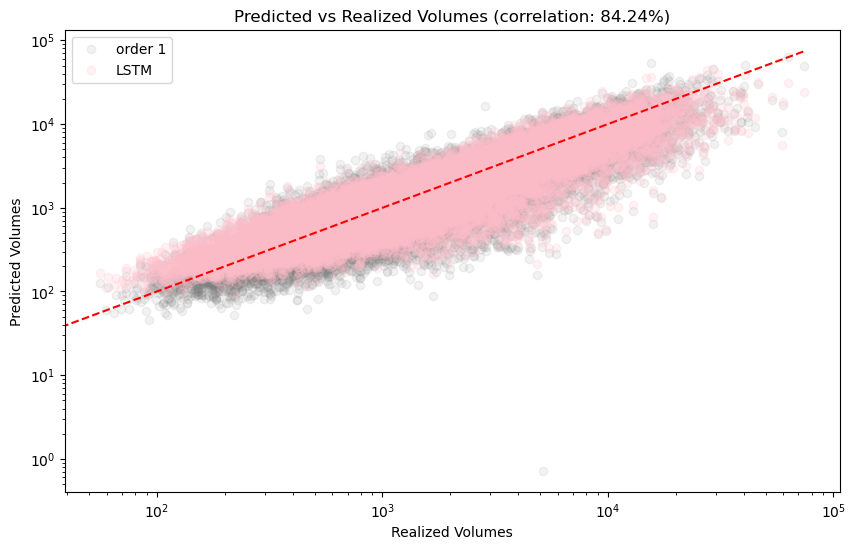

In [12]:
y_pred = lstm.predict(X_val)
R2 = r_squared(backend.constant(y_val), backend.constant(y_pred))
correlation = int(np.sqrt(R2)*10000)/100 if R2 > 0 else np.nan
print(R2)
# Plot the R^2 values
plt.figure(figsize=(10, 6))
plt.title(f'Predicted vs Realized Volumes (correlation: {correlation}%)')
plt.plot(y_val_1, y_pred_1, 'o', color='gray', alpha=.1, label='order 1')
plt.plot(y_val, y_pred, 'o', color='pink', alpha=.2, label=f'LSTM')
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], '--', color='red')
plt.xlabel("Realized Volumes")
plt.ylabel("Predicted Volumes")
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()